In [1]:
import os
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms
from captum.robust import PGD, FGSM

# from model import vit_base_patch16_224
# from timm.models import vit_base_patch16_224
import sys
sys.path.append('../')
from saliency import *
from utils import *
from plots import *

In [2]:
device = "cuda:1"

# model = vit_base_patch16_224(pretrained=False)
model = torch.load('/home/aneeshashmi/xai/vit_base_patch16_224_in21k_test-accuracy_0.96_chest.pth')
model = model.to(device)

In [3]:
# import shutil
# import random

# tb_test_img = random.sample(os.listdir("../../data/real_data/Tuberculosis/"), k=int(len(os.listdir("../../data/real_data/Tuberculosis/")) * 0.5))
# normal_test_img = random.sample(os.listdir("../../data/real_data/Normal/"), k=int(len(os.listdir("../../data/real_data/Normal/")) * 0.5))

# len(tb_test_img), len(normal_test_img)

# src = os.path.join("../../data/real_data/Tuberculosis/")
# trgt = os.path.join("../../data/real_data/test/Tuberculosis/")
# for img_path in tb_test_img:
#     shutil.move(os.path.join(src, img_path), os.path.join(trgt, img_path))


# src = os.path.join("../../data/real_data/Normal/")
# trgt = os.path.join("../../data/real_data/test/Normal/")
# for img_path in normal_test_img:
#     shutil.move(os.path.join(src, img_path), os.path.join(trgt, img_path))


In [4]:
image_folder = "/home/aneeshashmi/xai/data/real_data/Tuberculosis"
image_files = [
        f for f in os.listdir(image_folder) if f.endswith(".jpg") or f.endswith(".png")
    ]

transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomRotation((90,90)),
        transforms.CenterCrop(400),
        transforms.Resize((224, 224)),
        # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ]
)

image_path = os.path.join(image_folder, image_files[2])
image = Image.open(image_path)
img = transform(image)
img = img.unsqueeze(0)

pgd = PGD(model, lower_bound=0, upper_bound=1)
eps = 0.05

/share/anaconda3/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
(224, 224)
(224, 224)
(224, 224)


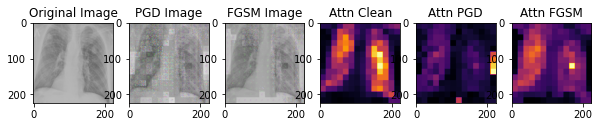

In [5]:
pgd_image = pgd.perturb(img.to(device), radius=0.13, step_size=eps, step_num=7, target=0) 
pgd_img = torch.tensor((pgd_image.cpu().data.numpy()))

fgsm = FGSM(model, lower_bound=0, upper_bound=1)
eps=0.05
fgsm_image = fgsm.perturb(img.to(device), epsilon=eps, target=0)
fgsm_img = torch.tensor((fgsm_image.cpu().data.numpy()))

img_attn = get_blk_attn(input_img=img.to(device), blk=11, model=model)
pgd_img_attn = get_blk_attn(input_img=pgd_img.to(device), blk=11, model=model)
fgsm_img_attn = get_blk_attn(input_img=fgsm_img.to(device), blk=11, model=model)

plt.figure(figsize=(10, 10))
text = ["Original Image", "PGD Image", "FGSM Image", "Attn Clean", "Attn PGD", "Attn FGSM"]
for i, fig in enumerate([img.squeeze(0).permute(2,1,0), pgd_img.squeeze(0).permute(2,1,0), fgsm_img.squeeze(0).permute(2,1,0), img_attn, pgd_img_attn, fgsm_img_attn]):
    print(fig.shape)
    plt.subplot(1, 6, i+1)
    plt.imshow(fig, cmap='inferno')
    plt.title(text[i])
plt.show()

# 1. Generate (test) samples

In [9]:
# image_folder = "/home/raza.imam/Documents/HC701B/Project/data/TB_data/testing/Tuberculosis/"
image_folder = "/home/aneeshashmi/xai/data/real_data/test/Tuberculosis"

block = 11
plot=False
rand=False
random_state=None
n_test_attns = 20
eps = 0.05

# For PGD 
attns_cln = [] #list of n test attentions
attns_pgd = []
attack = "PGD"
for i in range(n_test_attns):
    img, attn_cln, attn_adv, att_diff = test_img_attn(image_folder, block, model, plot=plot, rand=rand, random_state=random_state,
                                                      attack_type=attack, eps=eps, device=device)
    attns_cln.append(attn_cln)
    attns_pgd.append(attn_adv)
    
# For FGSM
attns_cln = [] #list of n test attentions
attns_fgsm = []
attack = "FGSM"
for i in range(n_test_attns):
    img, attn_cln, attn_adv, att_diff = test_img_attn(image_folder, block, model, plot=plot, rand=rand, random_state=random_state,
                                                      attack_type=attack, eps=eps, device=device)
    attns_cln.append(attn_cln)
    attns_fgsm.append(attn_adv)

img.device: cpu
img.device: cpu
img.device: cpu
img.device: cpu
img.device: cpu
img.device: cpu
img.device: cpu
img.device: cpu
img.device: cpu
img.device: cpu
img.device: cpu
img.device: cpu
img.device: cpu
img.device: cpu
img.device: cpu
img.device: cpu
img.device: cpu
img.device: cpu
img.device: cpu
img.device: cpu


In [10]:
np.sum(attn_cln), np.sum(attn_adv)

(254.03963, 254.63002)

torch.Size([224, 224, 3])
(224, 224)
(224, 224)


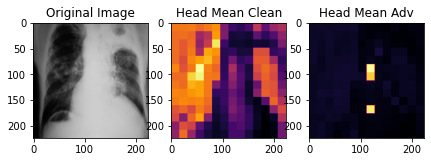

In [12]:
plt.figure(figsize=(7, 7))
text = ["Original Image", "Head Mean Clean", "Head Mean Adv"]
for i, fig in enumerate([img.squeeze(0).permute(2,1,0), attns_cln[0], attns_fgsm[0]]):
    print(fig.shape)
    plt.subplot(1, 3, i+1)
    plt.imshow(fig, cmap='inferno')
    plt.title(text[i])
plt.show()

# 2. Mean Attention of a block. For 2000 (train) images. 

In [18]:
from saliency import mean_attns_N_images
image_folder = "/home/raza.imam/Documents/HC701B/Project/data/TB_data/training/Tuberculosis/"
block = 11 #Select range from 0 to 11
N_images = 200
N_random = False
device = "cuda"

print(f"On Block {block}")
mean_attns_cln, mean_attns_adv, mean_attns_diff, attentions_clean, attentions_adv = mean_attns_N_images(image_folder=image_folder, N_images=N_images, 
                                                                      block=block, model=model, N_random=N_random, device=device, attack_type="FGSM")


On Block 11
torch.Size([200, 3, 224, 224])
mean_attns_cln.shape: (224, 224)


/home/raza.imam/.conda/envs/xaim/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


mean_attns_adv.shape: (224, 224)
mean_attns_diff.shape: (224, 224)


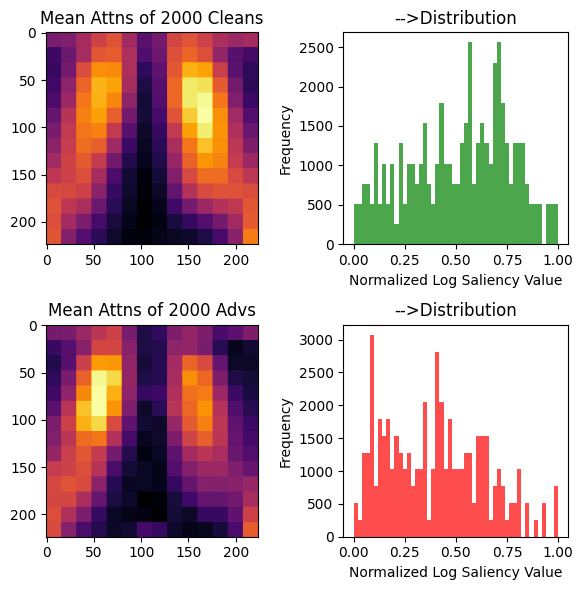

In [8]:
hist_plot(mean_attns_cln, mean_attns_adv, N_images)

In [33]:
np.mean(mean_attns_cln), np.mean(mean_attns_adv)

(0.0049512866, 0.0049310112)

# 3. Compare test sample attn with mean clean and adv attns

In [10]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
# Defining function
def classify_image_cos_similarity(test_attn, mean_attns_cln, mean_attns_adv): #np.dot(test_image,normal_image)/(norm(test_image)*norm(normal_image))
    # Flatten the images to 1D arrays (if not already flattened)
    test_attn_flat = test_attn.flatten()
    mean_attns_cln_flat = mean_attns_cln.flatten()
    mean_attns_adv_flat = mean_attns_adv.flatten()
    # Calculate cosine similarities
    similarity_to_normal = cosine_similarity([test_attn_flat], [mean_attns_cln_flat])
    similarity_to_adversarial = cosine_similarity([test_attn_flat], [mean_attns_adv_flat])

    print(f"similarity_to_normal: {similarity_to_normal}", f"similarity_to_adversarial: {similarity_to_adversarial}")
    # Compare similarity scores and classify
    if similarity_to_normal > similarity_to_adversarial:
        return "Clean"
    else:
        return "Adversarial"

#__main__
# result = classify_image_cos_similarity(attns_cln[4], mean_attns_cln, mean_attns_adv)
# print(f"Test image is classified as: {result}")


In [11]:
import numpy as np
from scipy.spatial.distance import euclidean
# Defining function
def classify_image_euclidean(test_attn, mean_attns_cln, mean_attns_adv): # np.sqrt(np.sum(np.square(test_attn - mean_attns_cln)))
    # Flatten the images to 1D arrays (if not already flattened)
    test_attn_flat = test_attn.flatten()
    mean_attns_cln_flat = mean_attns_cln.flatten()
    mean_attns_adv_flat = mean_attns_adv.flatten()
    # Calculate Euclidean distances
    distance_to_normal = euclidean(test_attn_flat, mean_attns_cln_flat)
    distance_to_adversarial = euclidean(test_attn_flat, mean_attns_adv_flat)
    
    print(f"distance_to_normal: {distance_to_normal}", f"distance_to_adversarial: {distance_to_adversarial}")
    # Compare distances and classify
    if distance_to_normal < distance_to_adversarial:
        return "Clean"
    else:
        return "Adversarial"

#__main__
# result = classify_image_euclidean(attns_cln[4], mean_attns_cln, mean_attns_adv)
# print(f"Test image is classified as: {result}")

In [12]:
def classify_image_sum(test_attn, mean_attns_cln, mean_attns_adv): #np.sum((test_attn - mean_attns_cln)) #FIXME:
    # Flatten the images to 1D arrays (if not already flattened)
    test_attn_flat = test_attn.flatten()
    mean_attns_cln_flat = mean_attns_cln.flatten()
    mean_attns_adv_flat = mean_attns_adv.flatten()
    # Calculate cosine similarities
    distance_to_normal = np.sum((test_attn_flat - mean_attns_cln_flat))
    distance_to_adversarial = np.sum((test_attn_flat - mean_attns_adv_flat))

    print(f"distance_to_normal: {distance_to_normal}", f"distance_to_adversarial: {distance_to_adversarial}")
    # Compare distances and classify
    if distance_to_normal < distance_to_adversarial:
        return "Clean"
    else:
        return "Adversarial"
    
#__main__
# result = classify_image_sum(attns_adv[4], mean_attns_cln, mean_attns_adv)
# print(f"Test image is classified as: {result}")

In [22]:
num_test_images = len(attns_pgd)
test_attns = attns_pgd

classifications = []
# Test each test image
for test_attn in test_attns:
    result = classify_image_euclidean(test_attn, mean_attns_cln, mean_attns_adv)
    classifications.append(result)

# Calculate accuracy
true_labels = ["Adversarial"] * num_test_images  # Assuming all test images should be classified as "Normal"
accuracy = sum(1 for true, predicted in zip(true_labels, classifications) if true == predicted) / num_test_images
print(f"Overall Accuracy: {accuracy * 100:.2f}%")


distance_to_normal: 0.562244176864624 distance_to_adversarial: 0.5069425106048584
distance_to_normal: 0.562244176864624 distance_to_adversarial: 0.5069425106048584
distance_to_normal: 0.562244176864624 distance_to_adversarial: 0.5069425106048584
distance_to_normal: 0.562244176864624 distance_to_adversarial: 0.5069425106048584
distance_to_normal: 0.562244176864624 distance_to_adversarial: 0.5069425106048584
distance_to_normal: 0.562244176864624 distance_to_adversarial: 0.5069425106048584
distance_to_normal: 0.562244176864624 distance_to_adversarial: 0.5069425106048584
distance_to_normal: 0.562244176864624 distance_to_adversarial: 0.5069425106048584
distance_to_normal: 0.562244176864624 distance_to_adversarial: 0.5069425106048584
distance_to_normal: 0.562244176864624 distance_to_adversarial: 0.5069425106048584
distance_to_normal: 0.562244176864624 distance_to_adversarial: 0.5069425106048584
distance_to_normal: 0.562244176864624 distance_to_adversarial: 0.5069425106048584
distance_to_norm